In [1]:
import os
import sys
REV_DIR = os.getcwd()
RES_DIR = os.path.dirname(REV_DIR)
ROOT_DIR = os.path.dirname(RES_DIR)
sys.path.append(ROOT_DIR)

In [2]:
import mlflow
from revision_utils import TRACKING_URI, BOOSTRAP_RUN_ID
from utils.serialization_ops import load_pickle

mlflow.set_tracking_uri(TRACKING_URI)
path = mlflow.artifacts.download_artifacts(
    "mlflow-artifacts:/6/{run_id}/artifacts/fold_result.pickle".format(run_id=BOOSTRAP_RUN_ID)
)
fold_results = load_pickle(path)

/home/heon/anaconda3/envs/3asc/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


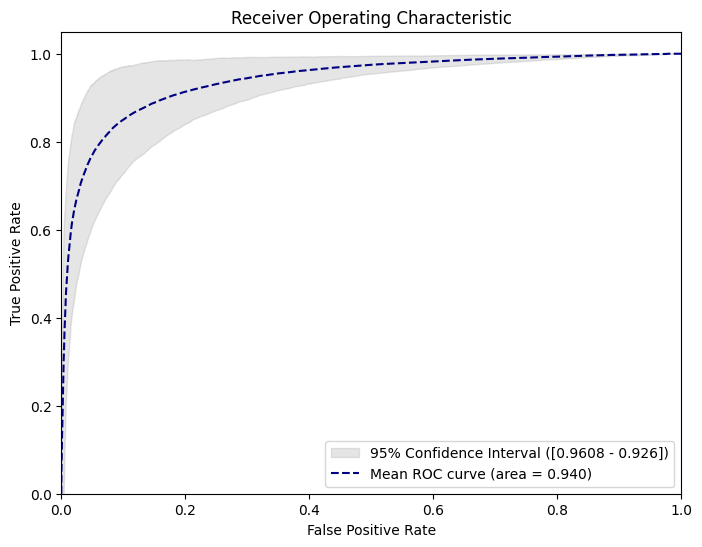

In [3]:
from core.metric import plot_cv_auroc_ci
fold_y_trues = fold_results["fold_bag_y_trues"]
fold_y_probs = fold_results["fold_bag_y_probs"]

plot_cv_auroc_ci(fold_y_trues, fold_y_probs)

In [4]:
# Color change
import seaborn as sns
sns.set_context('paper')
sns.set_color_codes('pastel')

In [5]:
import numpy as np
from core.metric import topk_recall
ks = [1, 2, 3, 4, 5, 10, 15, 20, 100]

n_fold = 30
performance = np.ones((n_fold, len(ks)))

for k_idx, k in enumerate(ks):
    for fold_idx, (instance_y_trues_at_fold, instance_y_probs_at_fold) in enumerate(
        zip(fold_results["fold_instance_y_trues"], fold_results["fold_instance_y_probs"])
    ):
        hits = list()
        for instance_y_true, instance_y_probs in zip(instance_y_trues_at_fold, instance_y_probs_at_fold):
            if instance_y_true.sum() == 0:
                continue

            hit = topk_recall(instance_y_probs, instance_y_true, k=k)
            hits.append(hit)

        performance[fold_idx, k_idx] = sum(hits) / len(hits)

print("-"*30 + "AVG" + "-"*30)
print(performance.mean(axis=0) * 100)
print("-"*30 + "Lower CI" + "-"*30)
print(np.quantile(performance, q=0.05, axis=0) * 100)
print("-"*30 + "Upper CI" + "-"*30)
print(np.quantile(performance, q=0.95, axis=0) * 100)

------------------------------AVG------------------------------
[75.3263761  87.6427256  91.55514631 93.65868631 94.40761203 95.74381011
 96.08553305 96.32289748 97.61203192]
------------------------------Lower CI------------------------------
[72.03499079 84.21731123 88.22897483 90.56783303 91.4825046  93.17372621
 93.60957643 93.79987723 95.06752609]
------------------------------Upper CI------------------------------
[77.81154082 90.16267649 93.60036832 95.65377532 96.4732965  97.66728054
 98.03560467 98.22590546 99.35850215]


In [22]:
import pandas as pd

df = pd.DataFrame(performance, columns=ks)
df.index.name = "fold"
df.reset_index(inplace=True)
sns.barplot(data=df, x="fold", color="b", y=ks, edgecolor="black", linewidth=0.5)

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

SNV only

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context('paper')
sns.set_color_codes('pastel')

from results.revision.revision_utils import get_snv_only_case, DATA_PATH
from core.metric import Metric
from utils.serialization_ops import load_pickle

patient_dataset = load_pickle(DATA_PATH)

ks = [1, 2, 3, 4, 5, 10, 15, 20, 100]
n_fold = len(fold_results["fold_instance_y_trues"])
performance = np.ones((n_fold, len(ks)))

for k_idx, k in enumerate(ks):
    for fold_idx in range(n_fold):
        test_ids = fold_results["test_ids"][fold_idx]
        snv_only_ids = get_snv_only_case(patient_dataset[test_ids])  
        
        test_indices = [test_ids.index(snv_id) for snv_id in snv_only_ids]

        instance_y_trues = [fold_results["fold_instance_y_trues"][fold_idx][_id] for _id in test_indices]
        instance_y_probs = [fold_results["fold_instance_y_probs"][fold_idx][_id] for _id in test_indices]
        topk = Metric.topk_recall(
            bag_labels=np.ones(len(instance_y_probs)), 
            instance_probs=instance_y_probs, 
            instance_labels=instance_y_trues, 
            k=k,
            is_any=True
        )
    
        performance[fold_idx, k_idx] = topk
        
df = pd.DataFrame(performance, columns=ks)
df.index.name = "fold"
sns.barplot(df, color="b", edgecolor="black", linewidth=0.5)

print("-"*30 + "AVG" + "-"*30)
print(performance.mean(axis=0) * 100)
print("-"*30 + "Lower CI" + "-"*30)
print(np.quantile(performance, q=0.05, axis=0) * 100)
print("-"*30 + "Upper CI" + "-"*30)
print(np.quantile(performance, q=0.95, axis=0) * 100)

FileNotFoundError: [Errno 2] No such file or directory: '/home/heon/dev/ASC3/dataset_positive_negative.pickle'

Figure 2-C

In [ ]:
import tqdm
from matplotlib import pyplot as plt
from revision_utils import DATA_PATH, get_cnv_only_case, get_topk_folds

print("Loading dataset to count CNV number")
ks = [1, 2, 3, 4, 5, 10, 15, 20, 100]

fold_results_mil_cnv = {"fold_instance_y_trues":list(), "fold_instance_y_probs":list()}
n_folds = len(fold_results["test_ids"])
for fold in tqdm.tqdm(range(n_folds)):
    test_ids = fold_results["test_ids"][fold_idx]
    cnv_only_ids = get_cnv_only_case(patient_dataset[test_ids])
    test_indices = [test_ids.index(snv_id) for snv_id in cnv_only_ids]
    instance_y_trues = [fold_results["fold_instance_y_trues"][fold_idx][_id] for _id in test_indices]
    instance_y_probs = [fold_results["fold_instance_y_probs"][fold_idx][_id] for _id in test_indices]
    fold_results_mil_cnv["fold_instance_y_trues"].append(instance_y_trues)
    fold_results_mil_cnv["fold_instance_y_probs"].append(instance_y_probs)

performnace_mil_cnv = get_topk_folds(
    fold_results_mil_cnv["fold_instance_y_trues"],
    fold_results_mil_cnv["fold_instance_y_probs"]
)

df = pd.DataFrame(performnace_mil_cnv, columns=ks)
df.index.name = "fold"
sns.barplot(df, color="b", edgecolor="black", errorbar="ci", linewidth=0.5)


print("-"*30 + "AVG" + "-"*30)
print(performnace_mil_cnv.mean(axis=0) * 100)
print("-"*30 + "Lower CI" + "-"*30)
print(np.quantile(performnace_mil_cnv, q=0.05, axis=0) * 100)
print("-"*30 + "Upper CI" + "-"*30)
print(np.quantile(performnace_mil_cnv, q=0.95, axis=0) * 100)

plt.savefig("results/3_4_boostrapping_topk_cnv.png")